# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [98]:
#Import packages for analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats as smd
import pylab
import matplotlib.cm as cm


# Turn edges on in plt
plt.rcParams["patch.force_edgecolor"] = True

# Matplotlib setup
%matplotlib inline

#np.random.seed(1000)

df = pd.read_csv('data/human_body_temperature.csv')

In [84]:
#View the dataset
print(df.head())

print(df.dtypes)


   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0
temperature    float64
gender          object
heart_rate     float64
dtype: object


In [85]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    
    return x, y

### Question #1: Is the distribution of body temperatures normal?

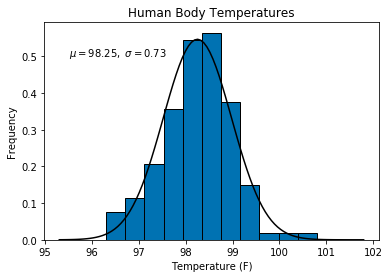

In [86]:
# Determine whether distribution is normal 
temp = df['temperature']

plt.style.use('seaborn-colorblind')

# Number of bins is square root of number of data points
n_bins = np.sqrt(len(temp))

# Must convert bins to integer
n_bins = int(n_bins)

# Plot histogram
_ = plt.hist(temp, density = True, bins = n_bins)

# Overlay PDF of the Standard Normal Distribution
x = np.linspace(np.min(temp) - 1, np.max(temp) + 1, 100, endpoint = True)
pdf = [stats.norm.pdf(_, loc = np.mean(temp), scale = np.std(temp)) for _ in x]
plt.plot(x, pdf, 'k-')

# Label histogram plot
_ = plt.text(95.5, .5, r'$\mu= {},\ \sigma={}$'.format(round(np.mean(temp), 2), round(np.std(temp), 2)))
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('Frequency')
_ = plt.title('Human Body Temperatures')

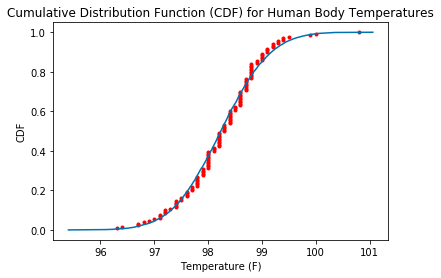

In [87]:
# Create and view additional plot, Cumulative Distribution Function (CDF)
plt.style.use('seaborn-colorblind')

# Plot CDFs
x, y = ecdf(temp)

# draw 10,000 random samples from a normal distribution
norm_temp = np.random.normal(np.mean(temp), np.std(temp), 10000)
norm_x, norm_y = ecdf(norm_temp)

# Plot and label figure

_ = plt.plot(x, y, marker = '.', linestyle = 'none', color = 'red')
_ = plt.plot(norm_x, norm_y)
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('CDF')
_ = plt.title('Cumulative Distribution Function (CDF) for Human Body Temperatures')

plt.show()

##### The first plot (histogram) shows the sample's distribution nearly perfectly distributed around the mean. The CDF plot shows the frequency distribution of the data to be close to normal with minimal outliers. The distribution of body temperatures appears normal.

### Question 2: Is the sample size large? Are the observations independent?

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


##### The sample size is large enough for Central Limit Theorem (CLT) to apply. A sample size of 30, given other factors, is generally accepted as "large enough."

>The central limit theorem states that the sum of a number of independent and identically distributed random variables with finite variances will tend to a normal distribution as the number of variables grows.

##### Because the data is unimodal and almost perfectly symmetrical around the mean, the sample size of 130 observations is enough to satisfy the "sufficiently large" requirement of the CLT. 

##### An independent variable is defined as "a variable whose variation does not depend on that of another." Given that knowing the outcome of one observation does not provide insight to another observation, the observations are independent. 


### Question 3: Is the true population mean really 98.6 degrees F?
##### First, try a bootstrap hypothesis test.
##### Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
##### In this situation, is it appropriate to use the  𝑡  or  𝑧  statistic?
##### Now try using the other test. How is the result be different? Why?

In [89]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


#### Bootstrap Hypothesis Test

##### Hypotheses: 
##### H<sub>0</sub> : mean of human body temperatures is equal to 98.6 degrees Fahrenheit
##### H<sub>b</sub> : mean of human body temperatures is **NOT** equal to 98.6 degrees Fahreheit

In [90]:
# Bootstrap hypothesis test - 10,000 samples
bs_replicates = np.empty(10000)

size = len(bs_replicates)

for i in range(size):
    bs_sample = np.random.choice(temp, len(temp))
    bs_replicates[i] = np.mean(bs_sample)
    
a = np.sum(bs_replicates >= 98.6) / size #98.6 is the number we're using as mean to test

print('p-value: {}'.format(a))
print('mean: {: .5}'.format(np.mean(bs_replicates)))


p-value: 0.0
mean:  98.249


### Results: 

##### 10,000 samples and the p-value is 0.0, meaning the null hypothesis should be rejected. From this bootstrap hypothesis test, the mean body temperature of the sample set is 98.25 degrees Fahrenheit.

#### Let's try increasing the number of samples and see if that changes the results

In [91]:
# Bootstrap hypothesis test - 250,000 samples
bs_replicates2 = np.empty(250000)

size2 = len(bs_replicates2)

for j in range (size2):
    bs_sample2 = np.random.choice(temp, len(temp))
    bs_replicates2[j] = np.mean(bs_sample2)
    
b = np.sum(bs_replicates2 >= 98.6) / size2

print('p-value: {}'.format(b))
print('mean: {: .5}'.format(np.mean(bs_replicates2)))


p-value: 0.0
mean:  98.249


### Results: 

##### 250,000 samples and the p-value is still 0.0, meaning that once again, the null hypothesis should be rejected. However, with more samples, the mean drew out an additional decimal place.

### Frequentist Approach:

##### A one-sample test because we are comparing the mean of a single sample to a population with a hypothesized mean.

In [92]:
t_stat = stats.ttest_1samp(temp, 98.6)
print('t_score: {}'.format(round(t_stat.statistic, 5)))
print('p-value: {}'.format(round(t_stat.pvalue, 5)))

t_score: -5.45482
p-value: 0.0


### Appropriate to use the t or Z statistic?

##### Because Z statistic requires the **population** standard deviation, the t statistic is the only option. The t statistic requires only the **sample** standard deviation.

### Question 4: Draw a small sample of size 10 from the data and repeat both frequentist tests.
#### Which one is the correct one to use?
#### What do you notice? What does this tell you about the difference in application of the  𝑡  and  𝑧  statistic?

In [93]:
sample_temp = np.random.choice(a = temp, size = 10)
b = stats.ttest_1samp(sample_temp, 98.6)
print('t-score: {:.4}'.format(b.statistic))
print('p-value: {:.4}'.format(b.pvalue))

t-score: 0.8327
p-value: 0.4266


##### t test is only option because population standard deviation is unknown. p-value greater than .05, null hypothesis cannot be rejected. Difference in application between t and Z statistic is largely dependent on the data available from both a sample and a population perspective.

### Question 5: At what temperature should we consider someone's temperature to be "abnormal"?
#### As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
#### Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

In [94]:
# First we must get the sample mean and standard deviation for use
xb = np.mean(temp)
std = np.std(temp)

print('The Average Mean of Our Sample is: {:.5}'.format(xb))
print('The Standard Deviation of Our Sample is: {:.5}'.format(std))

The Average Mean of Our Sample is: 98.249
The Standard Deviation of Our Sample is: 0.73036


#### Bootstrap Approach:

In [95]:
# First we must calculate the p-value using 250,000 bootstrap replicates

bootstrap_replicates2 = np.empty(250000)

size2 = len(bootstrap_replicates2)

for k in range(size2):
    bootstrap_sample2 = np.random.choice(temp, size = len(temp))
    bootstrap_replicates2[k] = np.mean(bootstrap_sample2)
    
p2 = np.sum(bootstrap_replicates2 >= 98.6) / len(bootstrap_replicates2)
print('p-value: {}'.format(p2))

xb2 = np.mean(bootstrap_replicates2)
ci = stats.norm.interval(.95, loc = xb2, scale = std)

print('95% Confidence Interval: {:.5} - {:.5}'.format(ci[0], ci[1]))
print('Margin of Error: +/-{:.5}\n\n'.format((ci[1] - xb2)))

p-value: 0.0
95% Confidence Interval: 96.818 - 99.681
Margin of Error: +/-1.4315




### Frequentist Approach:

In [96]:
# alpha = .05, confidence coefficient = 95%

ci_low, ci_high = stats.norm.interval(.95, loc = xb2, scale = std)
print('95% confidence interval: {:.5} - {:.5}'.format(ci_low, ci_high))

# still need to calculate margin of error
print('Margin of Error: +/-{:.5}'.format(ci_high - xb2))

95% confidence interval: 96.818 - 99.681
Margin of Error: +/-1.4315


### Results:

##### Both approaches utilized the same mean that we calculated of 98.249 degrees Fahrenheit and a 95% confidence interval. In both approaches the range for "normal" temperatures is 96.818 - 99.681 degrees Fahrenheit. This means anything less than 96.818 and greater than 99.681 degrees Fahrenheit would be considered abnormal.

### Question 6: Is there a significant difference between males and females in normal temperature?
#### What testing approach did you use and why?
#### Write a story with your conclusion in the context of the original problem.

##### Hypotheses: 
##### H<sub>0</sub> : males and females have equal normal temperature
##### H<sub>b</sub> : males and females do NOT have equal normal temperature

In [97]:
males = df[df['gender'] == 'M']
females = df[df['gender'] == 'F']

print('The number of male participants is: {}'.format(len(males)))
print('The number of female participants is: {}'.format(len(females)))
print('The total number of participants is: {}'.format(len(females + males)))

The number of male participants is: 65
The number of female participants is: 65
The total number of participants is: 130


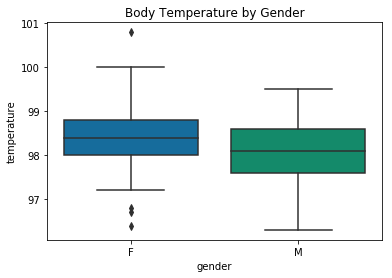

In [107]:
# Creating a plot for initial overview

sns.boxplot(x = 'gender', y = 'temperature', data = df)

_ = plt.title('Body Temperature by Gender')

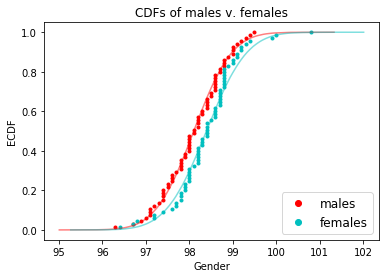

In [116]:
# Now lets check to see if both samples have normal distribution
plt.style.use('seaborn-colorblind')
# Compute ECDFs
x_males, y_males = ecdf(males.temperature)
x_females, y_females = ecdf(females.temperature)

# Time to create the plot
plt.plot(x_males, y_males, marker = '.', linestyle = 'none', color = 'r')
plt.plot(x_females, y_females, marker = '.', linestyle = 'none', color = 'c')

# Draw 250,000 random samples from a normal distribution
males_norm_dist = np.random.normal(np.mean(males.temperature), np.std(males.temperature), 250000)
males_nd_x, males_nd_y = ecdf(males_norm_dist)
_ = plt.plot(males_nd_x, males_nd_y, color = 'r', alpha = .5)

females_norm_dist = np.random.normal(np.mean(females.temperature), np.std(females.temperature), 250000)
females_nd_x, females_nd_y = ecdf(females_norm_dist)
_ = plt.plot(females_nd_x, females_nd_y, color = 'c', alpha = .5)

# Margins
plt.margins = .01

# Label the plot
_ = plt.xlabel('Gender')
_ = plt.ylabel('ECDF')
_ = plt.title('CDFs of males v. females')
_ = plt.legend(('males', 'females'), loc = 'lower right', fontsize = 'large', markerscale = 2)

In [117]:
# Check for both male and female variances
male_var = np.var(males.temperature)
female_var = np.var(females.temperature)

print('Male Variance: {}'.format(male_var))
print('Female Variance: {}'.format(female_var))

Male Variance: 0.4807479289940825
Female Variance: 0.5442698224852062


In [118]:
# Time to wrap it back around tothe null hypothesis, "males and females have equal normal temperature"
# Compare the variances and prove they are not equal using bootstrap

size = 250000

bs_replicates_males = np.empty(size)

for m in range(size):
    bs_sample_males = np.random.choice(males.temperature, len(males.temperature))
    bs_replicates_males[m] = np.var(bs_sample_males)
    
bs_var_males = np.sum(bs_replicates_males) / size

bs_replicates_females = np.empty(size)

for f in range(size):
    bs_sample_females = np.random.choice(females.temperature, len(females.temperature))
    bs_replicates_females[f] = np.var(bs_sample_females)
    
bs_var_females = np.sum(bs_replicates_females) / size

print('Bootstrap Comparison:')
print('Male Variance: {}'.format(bs_var_males))
print('Female Variance: {}'.format(bs_var_females))


Bootstrap Comparison:
Male Variance: 0.4732639793230769
Female Variance: 0.5357989334532535


In [124]:
# The bootstrap approach resulted in non-equal variances. The null hypothesis states that the means are equal; 
# We must now test the means of the two continuous distributions with a two-tailed t-test.
# First, lets identify important values for both males and females

xb_m = np.mean(males.temperature)
xb_f = np.mean(females.temperature)

std_m = np.std(males.temperature)
std_f = np.std(females.temperature)

# let's explore a 95% confidence interval for one draw
ci_low_males, ci_high_males = stats.norm.interval(.95, loc = xb_m, scale = std_m)

ci_low_females, ci_high_females = stats.norm.interval(.95, loc = xb_f, scale = std_f)

print('Sample Mean for Males: {:.5}'.format(xb_m))
print('Sample Mean for Females: {:.5}'.format(xb_f))
print()
print('Sample Standard Deviation for Males: {:.5}'.format(std_m))
print('Sample Standard Deviation for Females: {:.5}'.format(std_f))
print()
print('95% Confidence Interval for Males: {:.5} - {:.5}'.format(ci_low_males, ci_high_males))
print('95% Confidence Interval for Females: {:.5} - {:.5}'.format(ci_low_females, ci_high_females))


Sample Mean for Males: 98.105
Sample Mean for Females: 98.394

Sample Standard Deviation for Males: 0.69336
Sample Standard Deviation for Females: 0.73775

95% Confidence Interval for Males: 96.746 - 99.464
95% Confidence Interval for Females: 96.948 - 99.84


In [128]:
# Let's bootstrap the two-tailed t-test
size = 250000
bs_replicates_m1 = np.empty(size)

for q in range(size):
    bs_sample_m1 = np.random.choice(males.temperature, len(males.temperature))
    bs_replicates_m1[q] = np.mean(bs_sample_m1)
    
bs_mean_m1 = np.sum(bs_replicates_m1) / size

bs_replicates_f1 = np.empty(size)

for v in range(size):
    bs_sample_f1 = np.random.choice(females.temperature, len(females.temperature))
    bs_replicates_f1[v] = np.mean(bs_sample_f1)
    
bs_mean_f1 = np.sum(bs_replicates_f1) / size

final = stats.ttest_ind(bs_replicates_f1, bs_replicates_m1, equal_var = False)

print('2-tail t-test:')
print('t-statistic: {:.5}'.format(final[0]))
print('p-value: {:.5}'.format(final[1]))

2-tail t-test:
t-statistic: 1151.9
p-value: 0.0


#### Results:
##### There is a significant difference between males and females in normal temperature. We were able to confirm that females' mean body temperature is slightly higher than males' mean body temperature. A two-tailed t-test was used with a 95% confidence interval. Females' mean body temperature was found to be 98.394 degrees Fahrenheit and Males' mean body temperature was found to be 98.105 degrees Fahrenheit.

### Final Results:

##### This analysis began with an initial question of "What is the True Normal Human Body Temperature?" The sample of data available consisted of 130 samples, 65 male and 65 female. The data available had zero "null" values to adapt for. The value for the True Normal Human Body Temperature proposed was 98.6 degrees Fahrenheit and this was proven inaccurate and to be 98.25 degrees Fahreheit using a 95% confidence interval. 

##### The Central Limit Theorem applies in this situation as the distribution appeared normal and the sample size was sufficiently large. This allowed for inferences to be made which helped lead to our conclusion that the proposed value was incorrect. 